# Convolutional Networks for CAPTHA Recognition

- Introduction
- Datasets
- CNN MLP Architecture
- Training Preprocess
- Metrics
- Results
- conlusion

## I. Definition


### Project Overview

The CAPTHA Recognition is inspired by the MNINST/SVHN datasets and the hateness of annoying step before logging in or browsing pages. Although this step is for security concern, it is actually not helpful since the spirl of Machine Learning. Lots of websites,including government's sites, still use the  CAPTHAs. This project will reveal that even beginner as I can easily solve CAPTCHAs quickly. it is not only easy to machine to solve, but it annoy human users a lot. Based on the study :"How Good are Humans at Solving CAPTCHAs? A Large Scale Evaluation". it revealed that it is more effective for an attacker touse Mechanical Turk to solve captchas than an underground service.
chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://web.stanford.edu/~jurafsky/burszstein_2010_captcha.pdf



### Problem Statement

This problem is a classification of letters by computer vision. Use amounts of CAPTCHAs with various letters' fonts as input data. By Convolutional Netowrks, the CAPTCHAs images can't correctly predicted.
Because the images are formed by numbers 0~9 and letters A~Z, the expected output will be the text of 0~9 and A~Z. 

### Metrics

I use the accuracy and ROC curve to measure the performance of my models. Based on the characteristics of this problem, the score of accuracy must be high. After all, in real scenario, there is no partial right. The ROC curve is to evaluate the true positive rate versus false positive rate. 

## II. Analysis

### Data Exploration

The CAPTCHAs data samples are from the https://captcha.com/captcha-examples.html
A quantity of samples is 9,000. Every image is formated with 72x24 pixels and the backgrounds are all white. The postion of numbers and letters are almost at the center of images. Although the vertical position of each number or letter is not the same, the max height and max width of each number or letter are all the same. This characteristic is important if there are glue with each other, like "XWJE" as below. With the glue of both "W" and "J" letters, I can use the characteristic mentioned above to recognize and split the letters.

After I browsed whole datasets, I can sort images into five classes, all letters, all numbers, one number three letters, two numbers two letters and three numbers one letter. The amount of five classes images are almost random and all letters are capital. Except for all numbers and all letters, the sequence of letters and numbers are also random and there are no sign of dominant class; therefore, I can just randomly split the datasets into training/validation/testing.

(24, 72, 3)
uint8
127.5


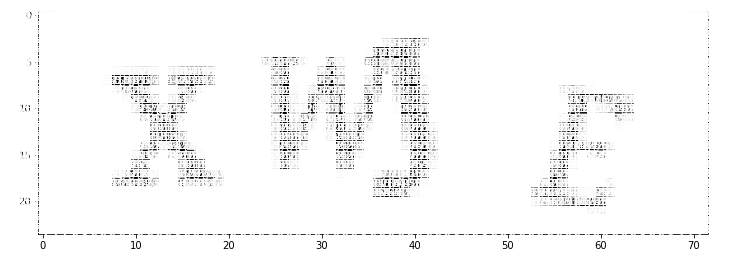

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
from PIL import Image
import cv2
import glob
from scipy import misc

#image = Image.open('C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\XWJE.PNG')
image = cv2.imread('C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\XWJE.PNG')
#image = misc.imread('C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\XWJE.PNG')
print (image.shape)
print (image.dtype)

def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width= img.shape[0]
    height = img.shape[1]
    thresh = img.max()/2
    print (thresh)
    for x in range(width):
        for y in range(height):
            ax.annotate(str(np.round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y].any() <thresh else 'black')
            


fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(image, ax)

In [3]:
from IPython.display import Image
display(
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\2A5R.PNG'),
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\XWJE.PNG')
)

![](https://cdn-images-1.medium.com/max/1200/1*leaOO0EYbgKVl7MEhflIFA.png)


### Solution Statement
For this kind of image recogition problem, the method flashed into my mind is Convolutional Neural Networks(CNN). Based on the properity of input datasets as mentioned above, at preprocessing step, I will firstly enchance the pixels of letters and numbers images pixels by openCV package, then split each number and letters into same pixels grouping and save them into files named "number(0~9)" or "letter(A~Z)". Secondly, I will map the labels into one-hot encoding by sklearn package. After preprocessing, I will build my CNN model by Keras package with Tensorflow backend. Because the simple complexity of my input datasets, I may just use two convolutional layers to enchance the computaional efficiency. 



### Benchmark Model
I plan to use Multiply Layers Perceptron(MLP) as bechmark models to compare the CNN. The idea is from the MLND projects "cifar10_mlp" and "cifar10_cnn". The CAPTCHAs datasets are well labeled like cifar datasets and even much simplier. I will also use Keras as tool to construct the MLP Model.



### Evaluation Metrics
Fisrt, I may use accuracy to evaluate the CNN and MLP model. Because, in real scenario, there is no tolerance of false judgement rate. Furthermore, The typical CAPTCHAs images, consisted of 0~9 and A~Z, consider  the upper and lower case as the same. Second, the ROC curve I will definitely use as reviewer advice. For MLP and CNN Models, I will test each model by diferent validation folds to verify the rate of true positive versus false positive. 



### Project Design

My traing data as below are images with random four letters, numbers and characters. the images files are named as their contents. However, we can find that images with four latters can be split to one letter, then we can use one letter image to train our model. it will reduce our computational time.
Therefore, In image preprocessing, I use findContours() of OpenCV function to split the boundaries of each letter in each image. Then I extract individual letters from images I have and save each letter in it's own folder. So with images preprocessing, our working flow is modified as below. 

The strategy I used is two Convolutional layers with two MaxPooling layers and two fully-connected layers(Dense), one is hidden layer and the others is output layer. I used the Multiply layer perceptron(MLP) as the benchmark model. the architecture as below is two fully-connected layers with two drop out layers. 

<img scr="C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\flow diagram.jpg">

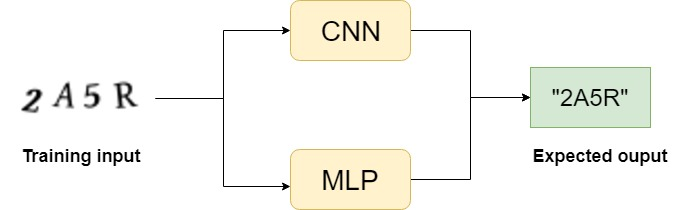

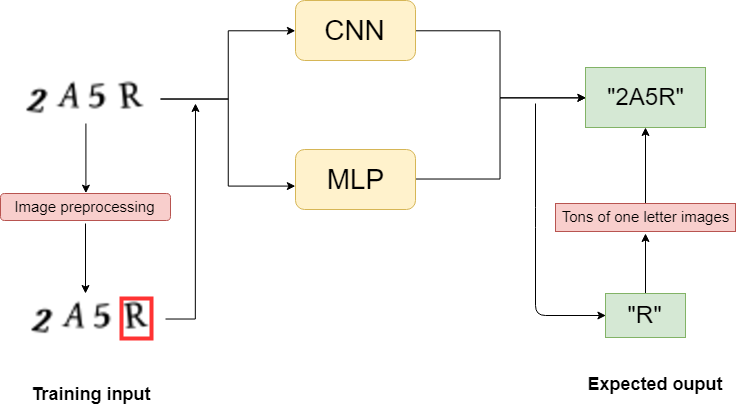

In [34]:
from IPython.display import Image
import nbconvert 
display (
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\flow diagram.jpg'),
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\flow diagram (9).png')
)

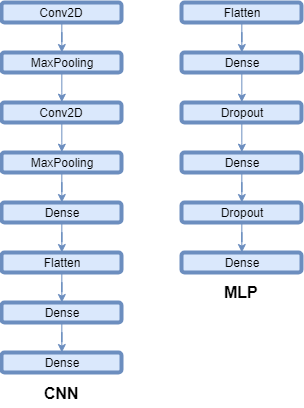

In [29]:
Image(filename = 'C:\\Users\\MLUSER\\Documents\\GitHub\\Udacity\\flow diagram (6).png')


-----------

**Before submitting your proposal, ask yourself. . .**

- Does the proposal you have written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Solution Statement** and **Project Design**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your proposal?
- Have you properly proofread your proposal to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?